In [1]:
import os
adir = '../../../data/ExVivo/Seqwell/'
project_name = 'exvivo2_20200318_mmul8_V4'
gcs = False

results_dir = '../../../results'

abase = os.path.join(adir, project_name)
abase

'../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4'

In [2]:
count_thresh=0
gene_thresh=300
mitothresh=.1
nhvgs = None
logstatus = 'log'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.gridspec as gridspec

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../Code')
from utils import read_adata, save_adata

sys.path.append('../../Code/cNMF/')

from cnmf import get_highvar_genes_sparse, save_df_to_npz

import palettable
from IPython.display import display, Image

from joblib import parallel_backend


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(scanpy=True, dpi=80, vector_friendly=False, ipython_format='png')


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


## Run cNMF to facilitate estimating SOUP contribution

In [6]:
processed_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
adata_annot = read_adata(processed_file, gcs=gcs)

Only considering the two last: ['.UMAP', '.h5ad'].
Only considering the two last: ['.UMAP', '.h5ad'].


In [7]:
adata = sc.AnnData(adata_annot.raw.X, obs=adata_annot.obs, var=adata_annot.raw.var, uns=adata_annot.uns)

In [8]:
sc.pp.filter_genes(adata, min_cells=10)

filtered out 945 genes that are detectedin less than 10 cells


In [9]:
adata = adata.copy()

In [10]:
cnmf_dir = adir

if not os.path.exists(cnmf_dir):
    os.mkdir(cnmf_dir)
    
name = 'cNMF.{project}'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus)
count_fn = os.path.join(cnmf_dir, name+ '.SubclusterMTNKB.h5ad')
count_fn_npz = os.path.join(cnmf_dir, name+ '.SubclusterMTNKB.npz')

hvg_fn = os.path.join(cnmf_dir, name+ '.SubclusterMTNKB.hvgs.txt')
print(count_fn)
print(count_fn_npz)
print(hvg_fn)

../../../data/ExVivo/Seqwell/cNMF.exvivo2_20200318_mmul8_V4.SubclusterMTNKB.h5ad
../../../data/ExVivo/Seqwell/cNMF.exvivo2_20200318_mmul8_V4.SubclusterMTNKB.npz
../../../data/ExVivo/Seqwell/cNMF.exvivo2_20200318_mmul8_V4.SubclusterMTNKB.hvgs.txt


In [11]:
sc.write(count_fn, adata)

Only considering the two last: ['.SubclusterMTNKB', '.h5ad'].
Only considering the two last: ['.SubclusterMTNKB', '.h5ad'].


In [12]:
X = pd.DataFrame(adata.X.todense(), index=adata.obs.index, columns=adata.var.index)

In [13]:

save_df_to_npz(X, count_fn_npz)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numpy/lib/format.py:356: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


## Picking high-variance genes excluding the cell cycle and freeze-thaw genes associated genes so they won't drive the usage inference but keeping them in the full data matrix so that their contribution will be estimated in the final set of GEPs

### This is running the cNMF hvg selection pipeline

In [14]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=(10**6))

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [15]:
gene_stats, _ = get_highvar_genes_sparse(adata.X, expected_fano_threshold=None,
                       minimal_mean=0.01, numgenes=2000)

In [16]:
hvgs = list(adata.var.index[gene_stats['high_var'].values])

In [17]:
open(hvg_fn, 'w').write('\n'.join(hvgs))

15467

In [18]:
numiter=20
numworkers=50
K = ' '.join([str(i) for i in range(10,25)])
seed = 14

In [19]:
## This isn't excecuting from the notebook so need to run from the shell
prepare_cmd = '/opt/miniconda3/bin/activate cnmf_env && python ../../Code/cNMF/cnmf.py prepare --output-dir %s --name %s -c %s -k %s --n-iter %d --total-workers %d --seed %d --beta-loss frobenius --genes-file %s' % (cnmf_dir, name, count_fn_npz, K, numiter, numworkers, seed,  hvg_fn)
print(prepare_cmd)
#! {prepare_cmd}

/opt/miniconda3/bin/activate cnmf_env && python ../../Code/cNMF/cnmf.py prepare --output-dir ../../../data/ExVivo/Seqwell/ --name cNMF.exvivo2_20200318_mmul8_V4 -c ../../../data/ExVivo/Seqwell/cNMF.exvivo2_20200318_mmul8_V4.SubclusterMTNKB.npz -k 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 --n-iter 20 --total-workers 50 --seed 14 --beta-loss frobenius --genes-file ../../../data/ExVivo/Seqwell/cNMF.exvivo2_20200318_mmul8_V4.SubclusterMTNKB.hvgs.txt


In [37]:
kselect_plot_cmd = 'python ../../Code/cNMF/cnmf.py k_selection_plot --output-dir %s --name %s' % (cnmf_dir, name)
print('K selection plot command: %s' % kselect_plot_cmd)
!{kselect_plot_cmd}

K selection plot command: python ../../Code/cNMF/cnmf.py k_selection_plot --output-dir ../../../data/ExVivo/Seqwell/ --name cNMF.exvivo2_20200318_mmul8_V4
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only consideri

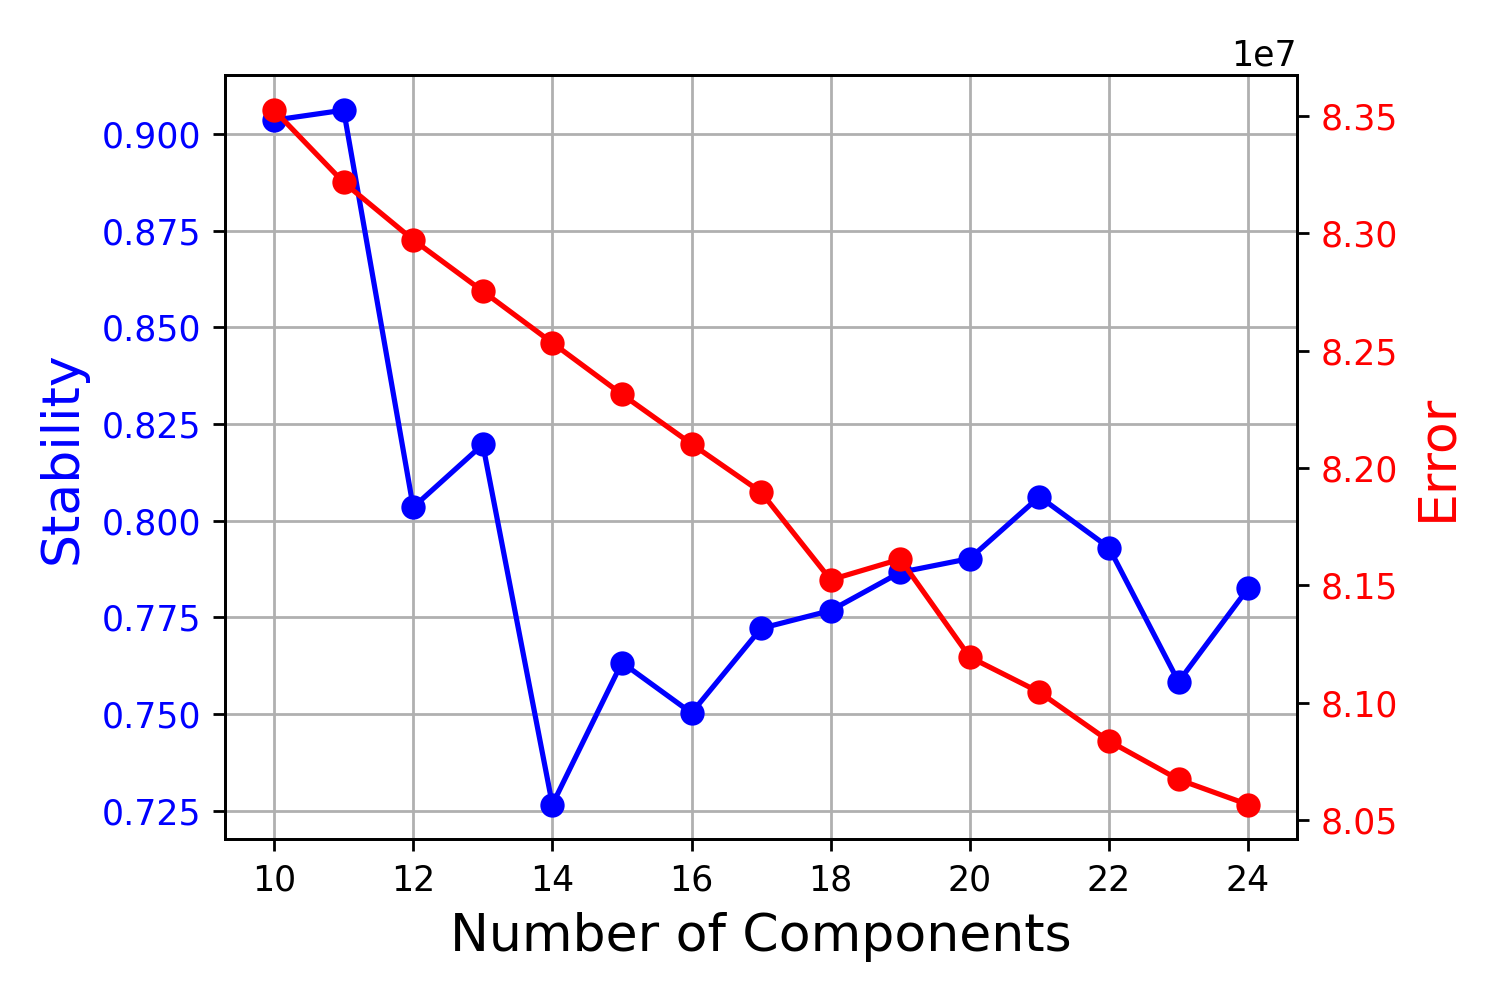

In [38]:
K_selection_plot_fn = os.path.join(cnmf_dir, name, name+'.k_selection.png')
Image(K_selection_plot_fn)

In [40]:
selected_K = 13
density_threshold = 2.00

In [43]:
consensus_cmd = 'python ../../Code/cNMF/cnmf.py consensus --output-dir %s --name %s --local-density-threshold %.2f --components %d --show-clustering' % (cnmf_dir, name, density_threshold, selected_K)
print('Consensus command for K=13:\n%s' % consensus_cmd)
!{consensus_cmd}

Consensus command for K=13:
python ../../Code/cNMF/cnmf.py consensus --output-dir ../../../data/ExVivo/Seqwell/ --name cNMF.exvivo2_20200318_mmul8_V4 --local-density-threshold 2.00 --components 13 --show-clustering
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Only considering the two last: ['.norm_counts', '.h5ad'].
Only conside

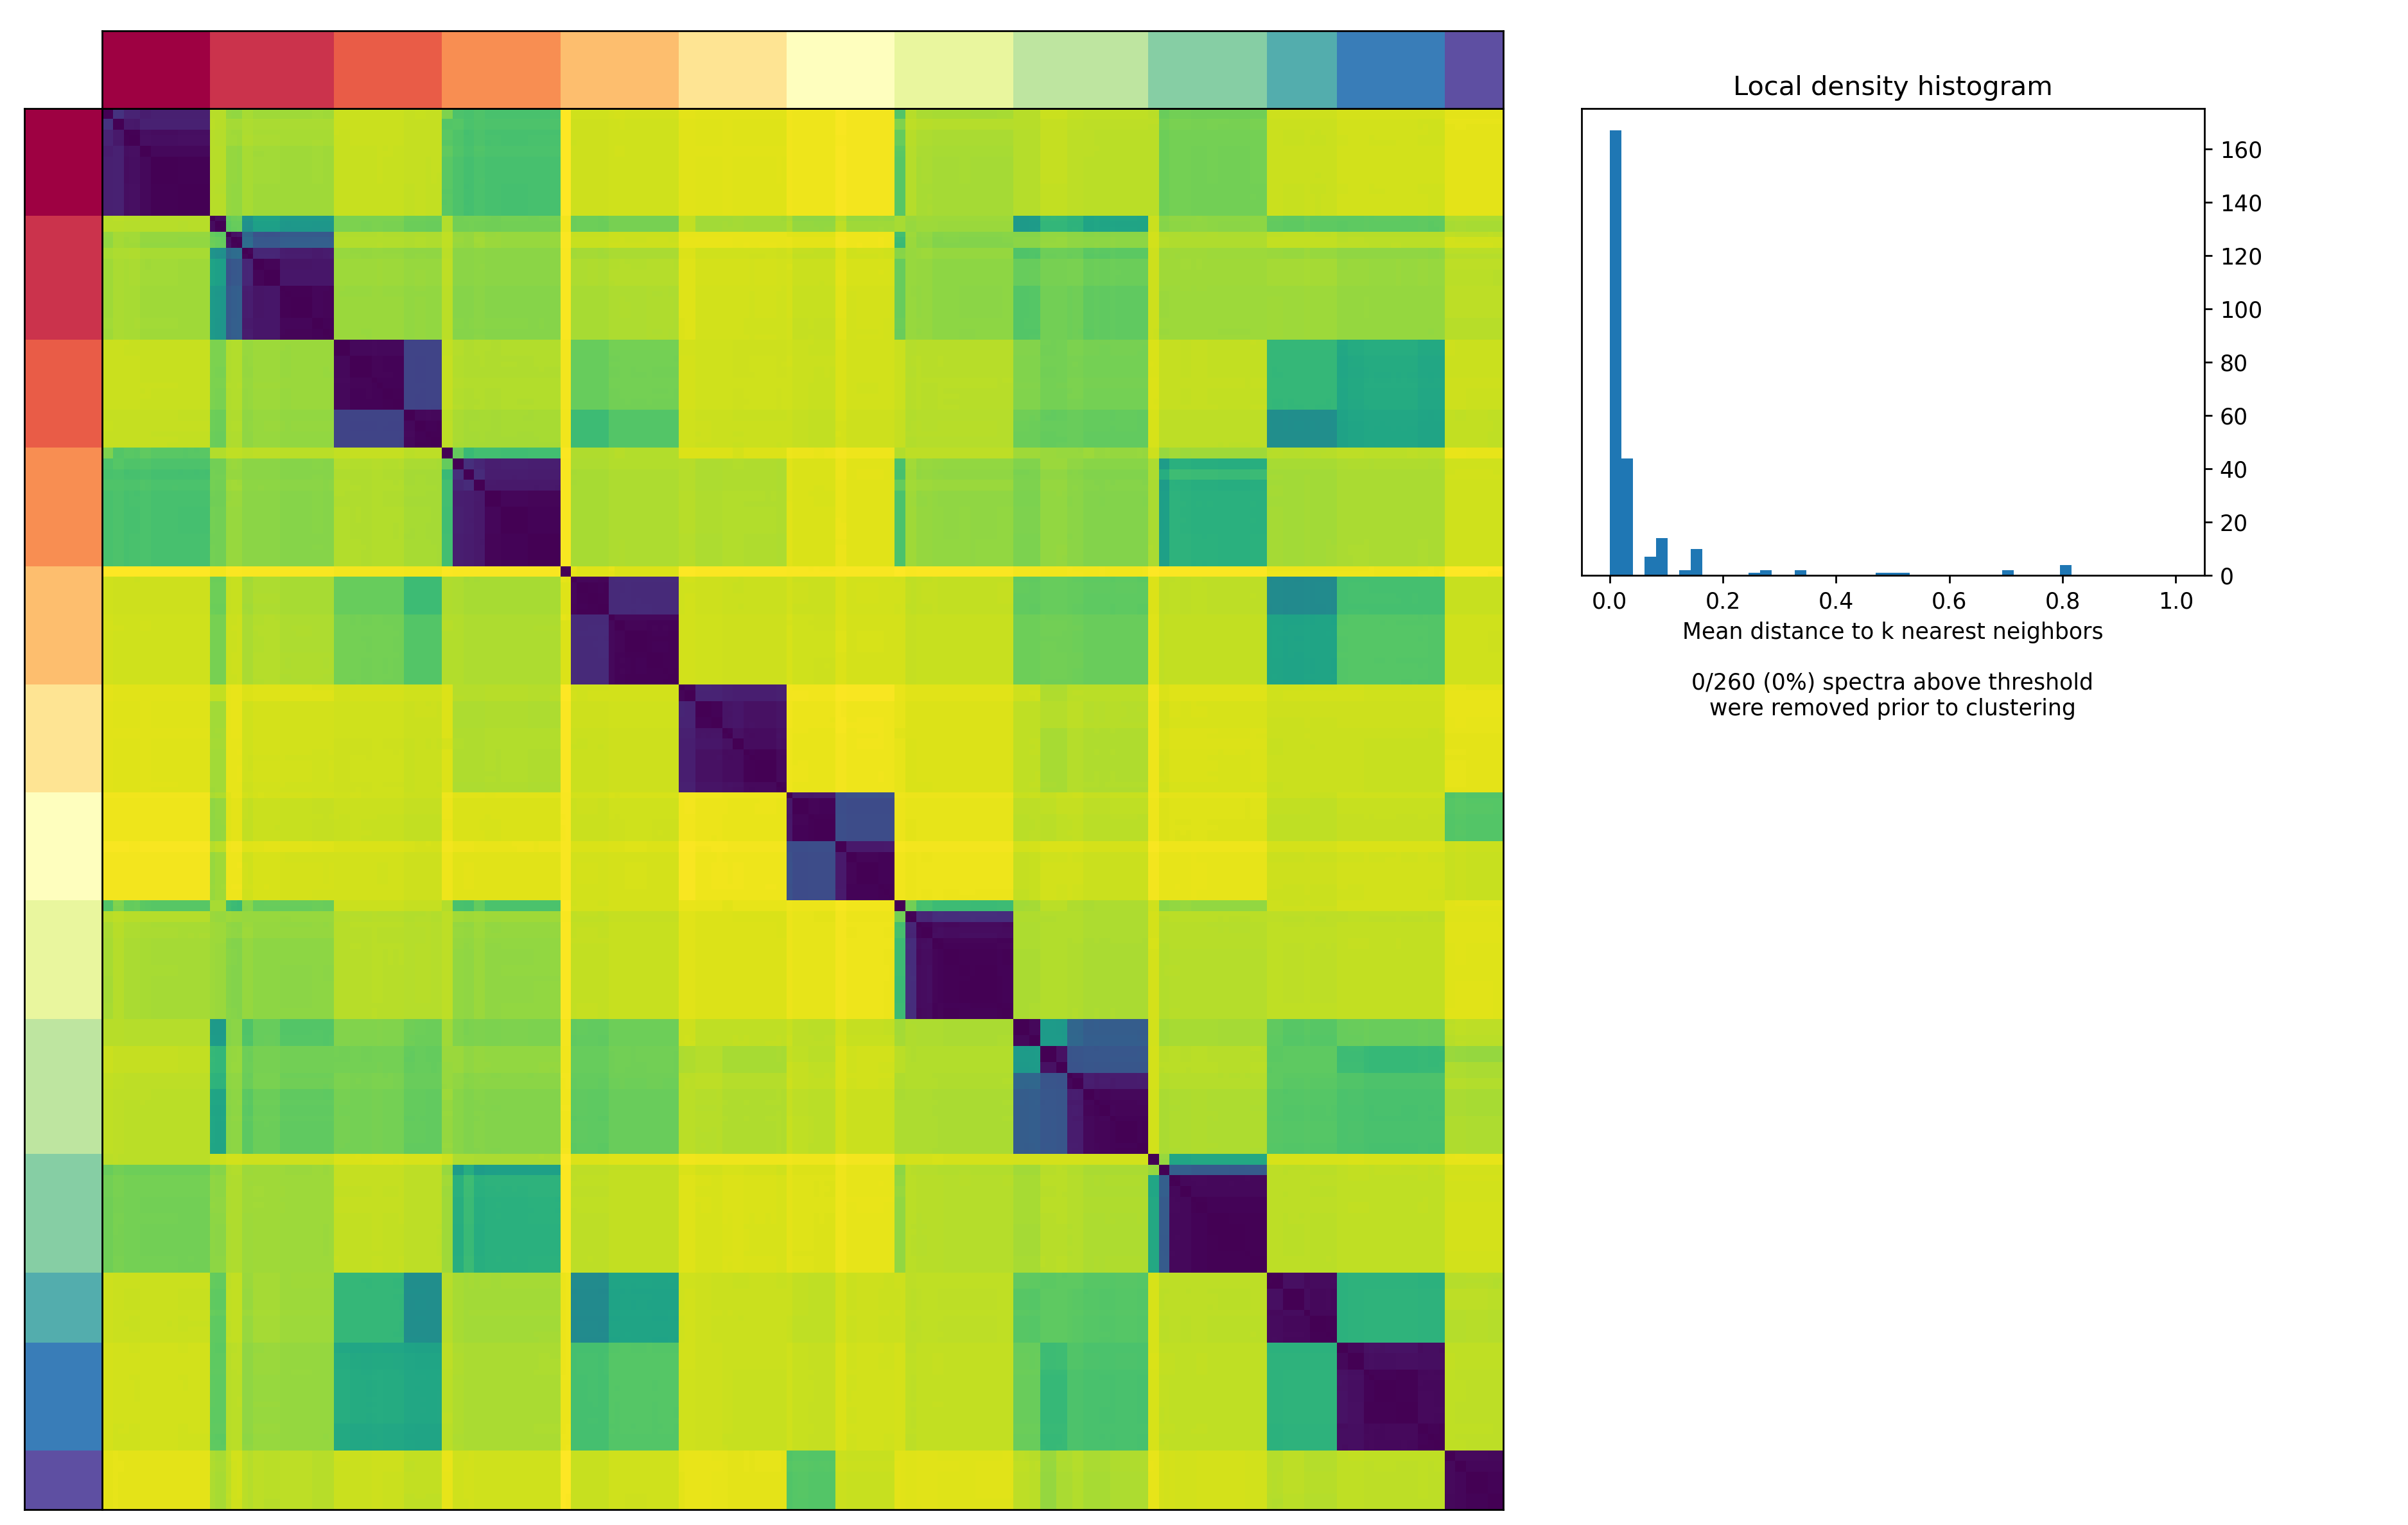

In [44]:
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')

consensus_plot_fn = os.path.join(cnmf_dir, name, name+".clustering.k_%d.dt_%s.png" % (selected_K, density_threshold_str))
Image(filename = consensus_plot_fn,
      width=1000, height=1000)

In [45]:
selected_K = 13
density_threshold = 0.10
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')


In [46]:
consensus_cmd = 'python ../../Code/cNMF/cnmf.py consensus --output-dir %s --name %s --local-density-threshold %.2f --components %d --show-clustering' % (cnmf_dir, name, density_threshold, selected_K)
print('Consensus command for K=13:\n%s' % consensus_cmd)
!{consensus_cmd}

Consensus command for K=13:
python ../../Code/cNMF/cnmf.py consensus --output-dir ../../../data/ExVivo/Seqwell/ --name cNMF.exvivo2_20200318_mmul8_V4 --local-density-threshold 0.10 --components 13 --show-clustering
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Only considering the two last: ['.norm_counts', '.h5ad'].
Only conside

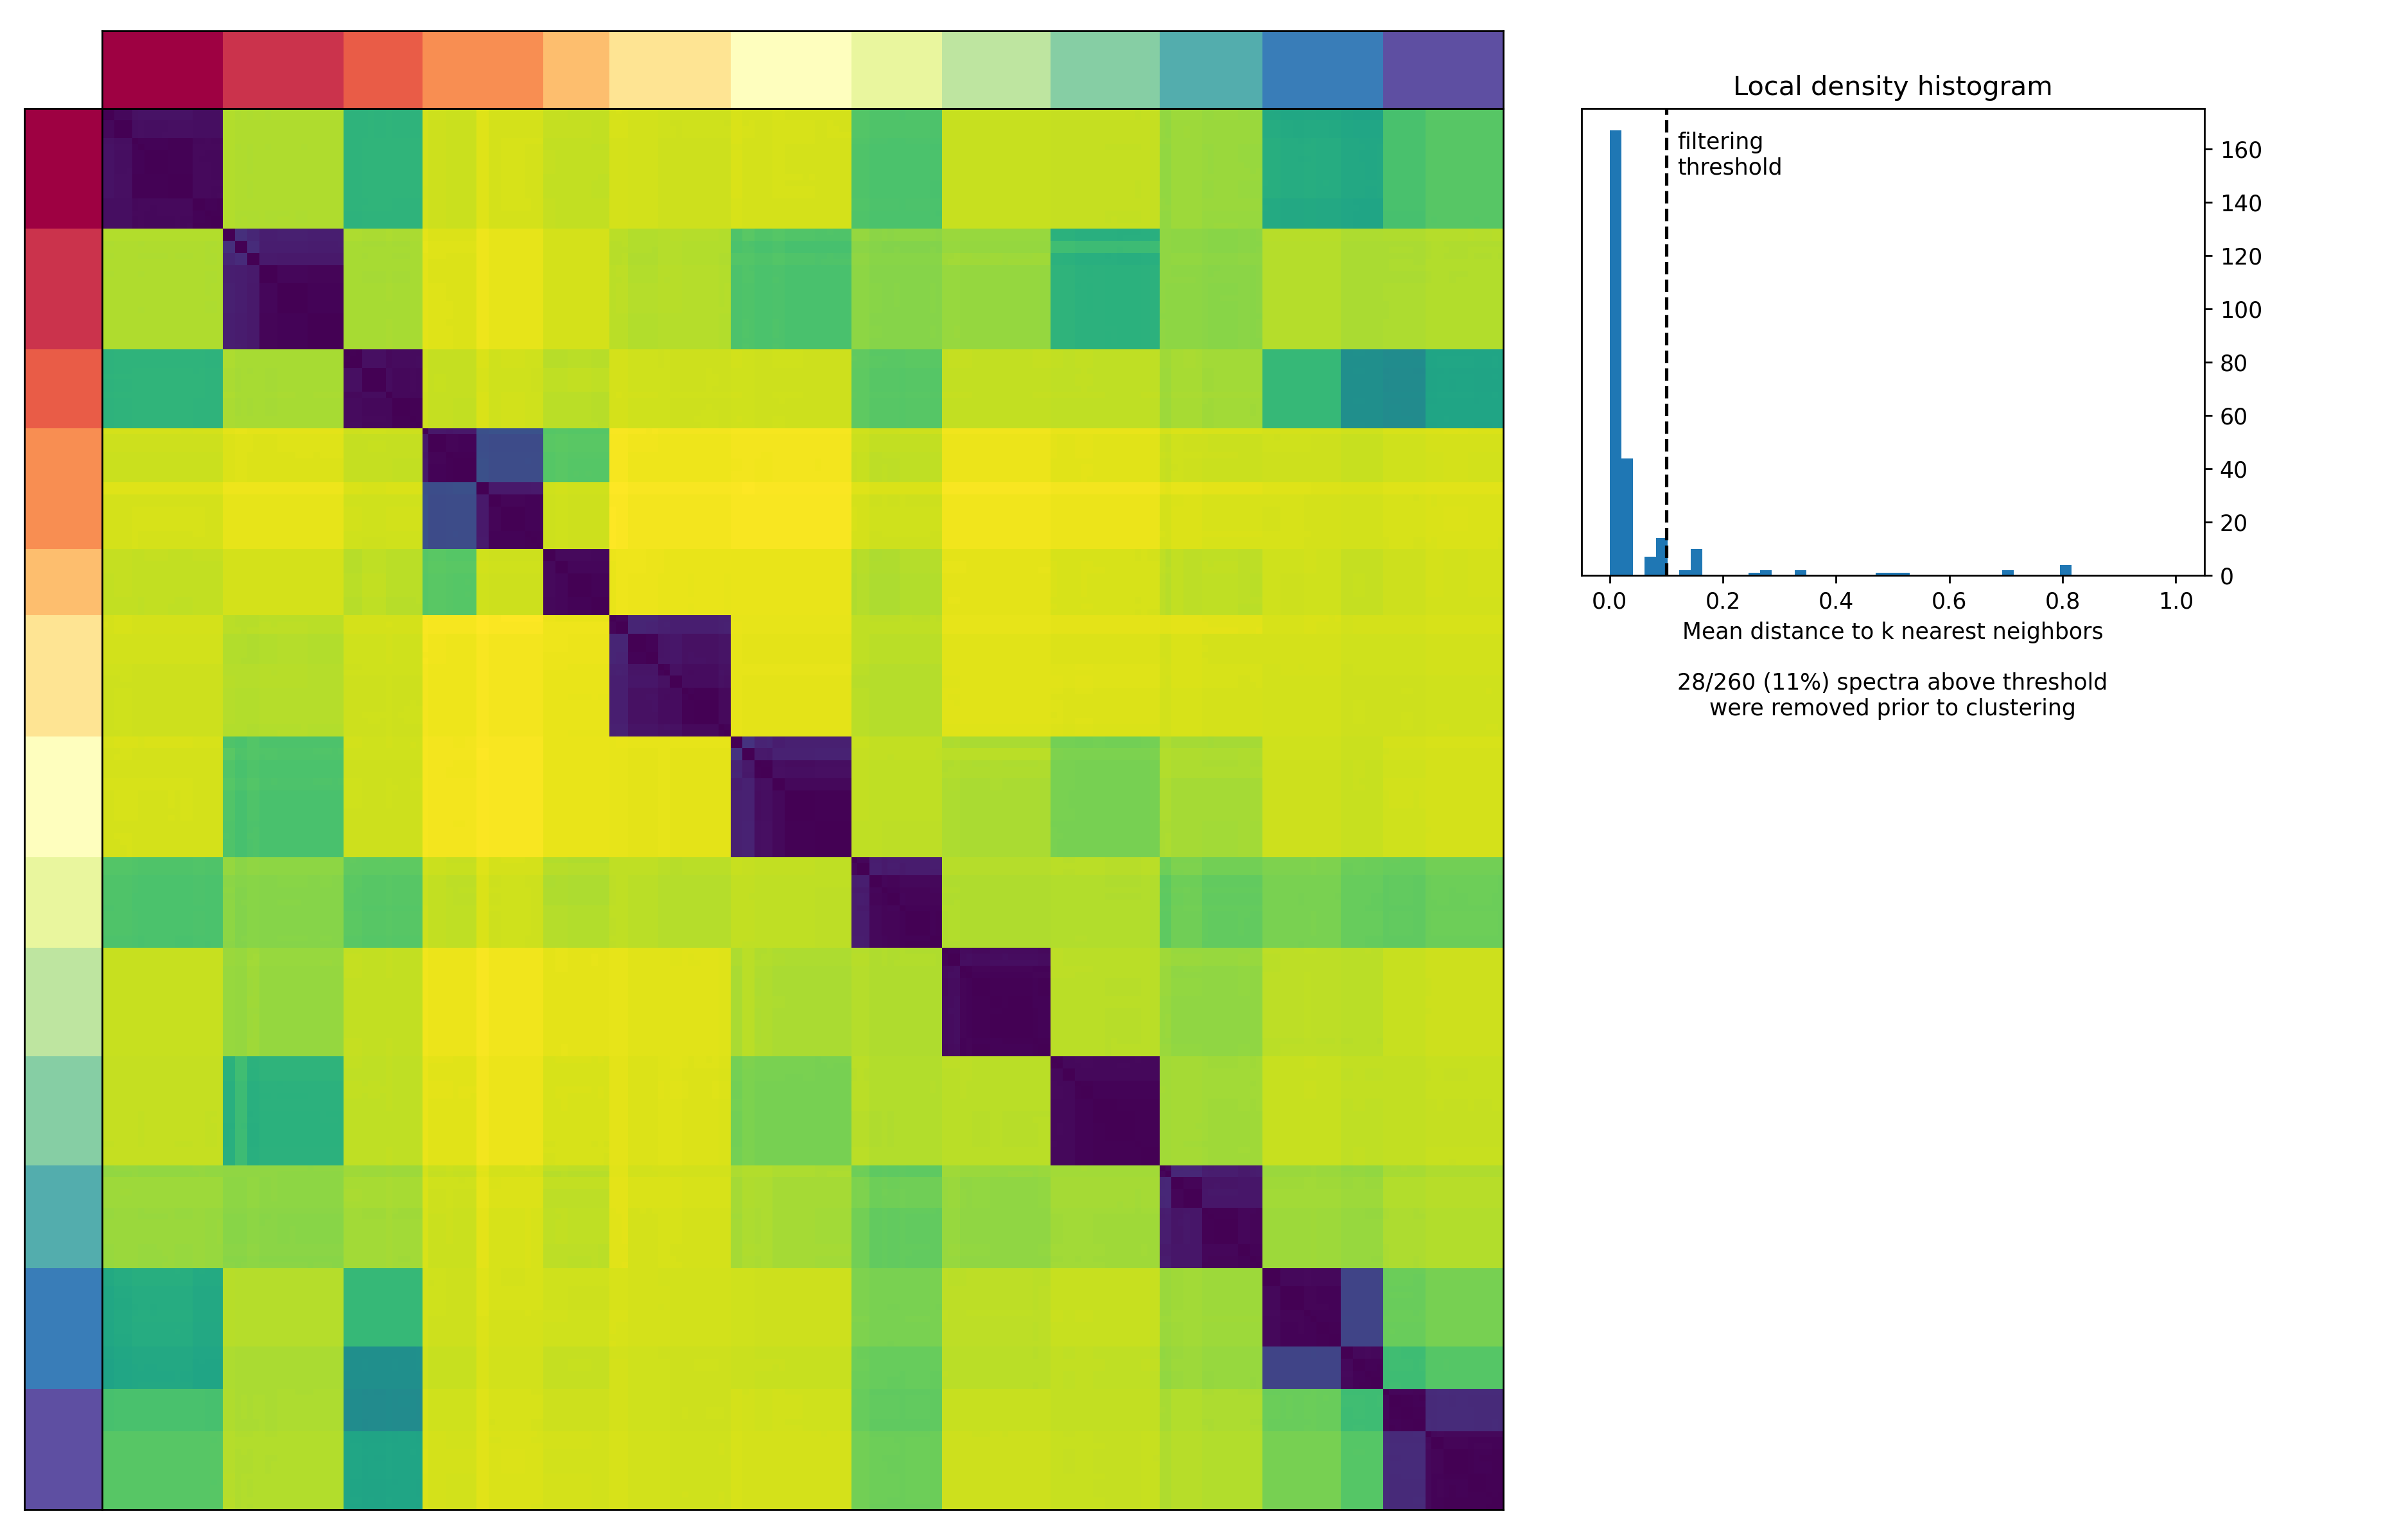

In [47]:
consensus_plot_fn = os.path.join(cnmf_dir, name, name+".clustering.k_%d.dt_%s.png" % (selected_K, density_threshold_str))
Image(filename = consensus_plot_fn,
      width=1000, height=1000)

In [48]:
usage_fn = os.path.join(cnmf_dir, name, name+".usages.k_%d.dt_%s.consensus.txt" % (selected_K, density_threshold_str))

usage = pd.read_csv(usage_fn, sep='\t', index_col=0)
usage.columns = ['Usage_%s' % i for i in usage.columns]
usage_norm = usage.div(usage.sum(axis=1), axis=0)
usage_norm.head()

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7,Usage_8,Usage_9,Usage_10,Usage_11,Usage_12,Usage_13
index,,,,,,,,,,,,,
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAAAAAATGCC,0.026191,0.053065,0.000000,0.011378,0.000000,0.000000,0.879982,0.029385,0.000000,0.000000,0.000000,0.000000,0.000000
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTCGTGGT,0.505190,0.025820,0.081728,0.000000,0.000000,0.010054,0.040356,0.183777,0.024118,0.000000,0.000000,0.109258,0.019698
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTGCCTTG,0.444726,0.000000,0.370098,0.034488,0.000000,0.000000,0.000000,0.000000,0.000000,0.033647,0.031892,0.085149,0.000000
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAATCATTCTC,0.049228,0.000000,0.090518,0.000000,0.000000,0.000000,0.024459,0.458012,0.027655,0.000000,0.251849,0.098279,0.000000
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAACACTATTTT,0.081850,0.023546,0.097075,0.000000,0.013499,0.000000,0.014339,0.769691,0.000000,0.000000,0.000000,0.000000,0.000000


In [49]:
adata = sc.read(count_fn)

Only considering the two last: ['.SubclusterMTNKB', '.h5ad'].
Only considering the two last: ['.SubclusterMTNKB', '.h5ad'].


In [50]:
adata

AnnData object with n_obs × n_vars = 48721 × 15795 
    obs: 'batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI', 'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes', 'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_hbb', 'leiden', 'leiden_lab', 'leiden_lab_group', 'Subclustering', 'SubclusteringGroup', 'Doublet'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'CC_Blacklist'
    uns: 'SubclusteringGroup_colors', 'condition_colors', 'hour_colors', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors'

In [51]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10000)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [52]:
sc.pp.log1p(adata)

In [53]:
sc.pp.highly_variable_genes(adata, n_top_genes=nhvgs)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [54]:
adata.var['highly_variable'].value_counts()

False    13703
True      2092
Name: highly_variable, dtype: int64

In [55]:
adata.raw = adata.copy()

In [56]:
adata = adata[:, adata.var['highly_variable']]
sc.pp.scale(adata, max_value=10)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:06)


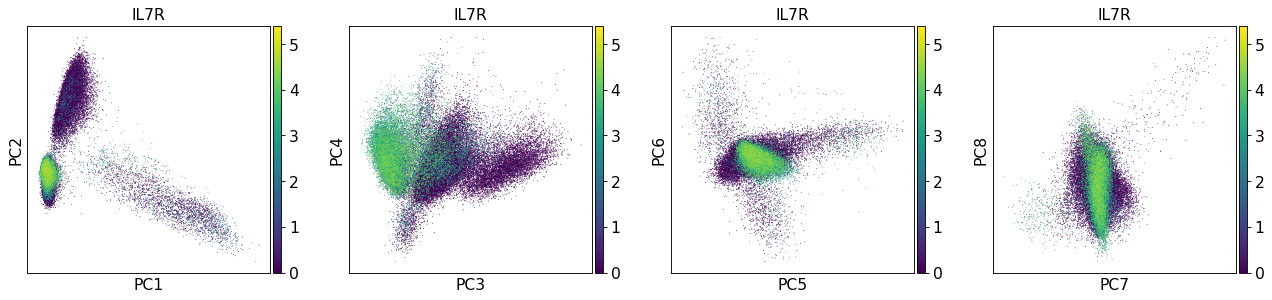

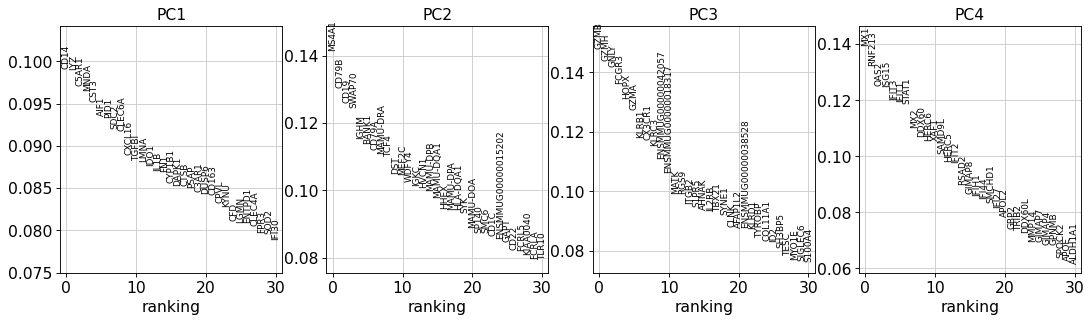

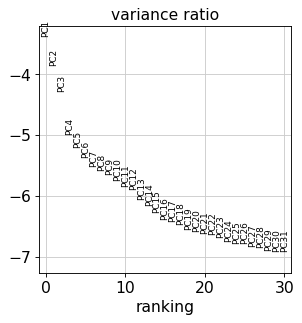

In [57]:
sc.tl.pca(adata, svd_solver='arpack', random_state=14)

sc.pl.pca(adata, components=['1,2', '3,4', '5,6', '7,8'], color=['IL7R'],
          ncols=4, use_raw=True)

sc.pl.pca_loadings(adata, components=[1,2,3,4])

sc.pl.pca_variance_ratio(adata, log=True)


In [58]:
adata

AnnData object with n_obs × n_vars = 48721 × 2092 
    obs: 'batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI', 'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes', 'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_hbb', 'leiden', 'leiden_lab', 'leiden_lab_group', 'Subclustering', 'SubclusteringGroup', 'Doublet'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'CC_Blacklist', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SubclusteringGroup_colors', 'condition_colors', 'hour_colors', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [59]:
with parallel_backend('threading', n_jobs=15):
    sc.pp.neighbors(adata, n_neighbors=int(adata.shape[0]*.001), n_pcs=20, random_state=14)
    
with parallel_backend('threading', n_jobs=15):
    sc.tl.umap(adata, min_dist=0.1, spread=2.0, random_state=14)

computing neighbors
    using 'X_pca' with n_pcs = 20


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../..

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:48)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:41)


In [60]:
adata.obs = pd.merge(left=adata.obs, right=usage_norm, how='left', left_index=True, right_index=True)

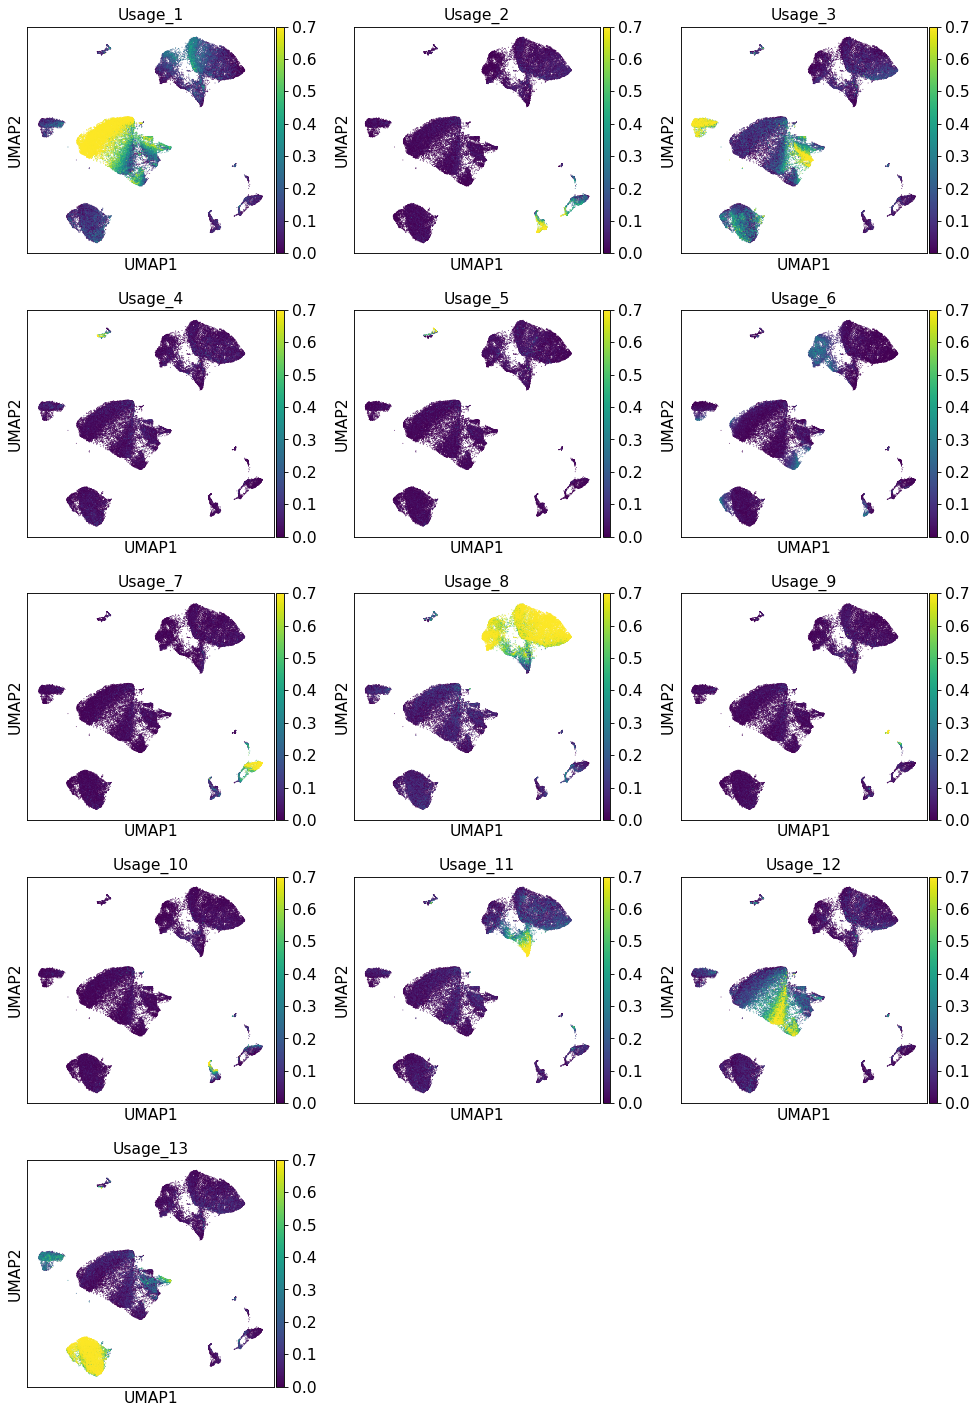

In [61]:

sc.pl.umap(adata, color=usage_norm.columns,
           use_raw=True, ncols=3, vmin=0, vmax=.7)

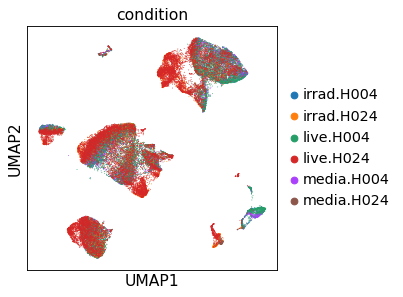

In [62]:
sc.pl.umap(adata, color='condition')

In [63]:
gene_score_fn = os.path.join(cnmf_dir, name, name+".gene_spectra_score.k_%d.dt_%s.txt" % (selected_K, density_threshold_str))
gene_scores = pd.read_csv(gene_score_fn,
                    sep='\t', index_col=0).T
gene_scores.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
EBOV-GENOME,-0.000111,-0.000552,-0.000077,-0.000054,-0.000003,1.086923e-04,-0.000063,-0.000086,0.000389,0.004016,-0.000244,-0.000197,-0.000164
EBOV-GP,-0.000124,-0.000663,-0.000065,-0.000021,-0.000031,-2.381141e-05,-0.000096,-0.000070,0.000328,0.004586,-0.000300,-0.000158,-0.000183
EBOV-L,-0.000126,-0.000596,-0.000084,-0.000018,-0.000050,-1.982719e-05,-0.000189,-0.000073,0.000699,0.004590,-0.000324,-0.000201,-0.000171
EBOV-NP,-0.000148,-0.000554,-0.000102,-0.000016,-0.000051,-2.836276e-07,-0.000198,-0.000087,0.000392,0.004698,-0.000291,-0.000170,-0.000187
EBOV-VP24,-0.000130,-0.000724,-0.000082,-0.000019,-0.000046,7.106899e-05,-0.000181,-0.000079,0.000439,0.004662,-0.000292,-0.000155,-0.000176


In [64]:
top_genes = []
ngenes = 20
for gep in gene_scores.columns:
    top_genes.append(list(gene_scores.sort_values(by=gep, ascending=False).index[:ngenes]))
    
top_genes = pd.DataFrame(top_genes, index=gene_scores.columns).T
top_genes

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,PECAM1,TGFBI,CCR5,TOP2A,ENSMMUG00000002764,MX1,IL1B,CD79B,FSCN1,EBOV-VP35,CD83,ITGB1,GNLY
1,CA6,LIPA,CLIC5,MKI67,ENSMMUG00000038560,IFIT1,OLR1,CD79A,TNNT2,EBOV-VP30,HSP90AB1,BICDL1,FCGR3
2,SELL,CTSB,GZMK,DLGAP5,JCHAIN,OAS2,CD14,MS4A1,FLT3,EBOV-NP,FCRL5,DUSP16,GZMH
3,TCF7,PSAP,TGFBR3,ASPM,MZB1,MX2,FCGR2A,CD19,LAMP3,EBOV-VP24,BCL2A1,CREM,GZMB
4,ITGA6,LYZ,ENSMMUG00000038528,CCNB2,IGKC,ISG15,PTGS2,MAMU-DRA,CLIC2,EBOV-VP40,IRF4,ICOS,KLRC3
5,RFLNB,CLEC6A,ZBTB38,BIRC5,ENSMMUG00000015202,IFIT3,ANXA5,MAMU-DPB,RAMP1,EBOV-L,CSF1,PTPN13,GZMA
6,LEF1,CST3,CXCR6,CEP55,ENSMMUG00000044861,HERC5,FN1,BANK1,TMEM176B,EBOV-GP,NR4A3,SPOCK2,HOPX
7,RPS3,STAB1,CD2,NUSAP1,BHLHA15,IFIT2,CYP1B1,SYK,ARHGAP22,EBOV-GENOME,NIN,AP3M2,KLRB1
8,RPS14,TNFRSF21,ADAM23,KIF4A,ENSMMUG00000040311,RNF213,PID1,WDFY4,TXN,ENSMMUG00000012749,NFKBID,ITM2A,CX3CR1
9,TMEM63A,ALDH1A1,ENSMMUG00000020920,HIST1H1B,HSP90B1,IFI6,VEGFA,KIAA0040,TMEM176A,ENSMMUG00000031944,REL,EGLN3,ENSMMUG00000018317


## Estimate ambient RNA contamination

In [65]:
spectra_fn = os.path.join(cnmf_dir, name, name+".gene_spectra_tpm.k_%d.dt_%s.txt" % (selected_K, density_threshold_str))
spectra = pd.read_csv(spectra_fn, sep='\t', index_col=0)
spectra.head()

,EBOV-GENOME,EBOV-GP,EBOV-L,EBOV-NP,EBOV-VP24,EBOV-VP30,EBOV-VP35,EBOV-VP40,CCNF,TEDC2,...,ENSMMUG00000049216,STUB1,ENSMMUG00000049226,IER5L,ENSMMUG00000049230,AMMECR1L,ENSMMUG00000049233,ZNF736,MIR3661,ENSMMUG00000049259
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.201885,0.000000,...,4.843404,98.474595,0.000000,0.154911,0.122006,63.879557,0.289255,1.968958,0.204889,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.740699,0.000000,...,5.791665,76.941529,0.000000,3.997726,0.898067,62.637306,0.000000,1.561355,0.637331,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.921253,0.000000,...,2.836345,113.127000,0.000000,0.000000,0.688175,65.655797,0.000000,0.520516,0.869106,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250.593656,46.423835,...,9.526380,14.198805,22.517375,0.000000,0.000000,81.062919,0.000000,0.000000,0.000000,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,9.065533,...,0.000000,105.458416,9.614223,0.095709,0.000000,0.000000,0.000000,0.000000,3.305048,1.442189


In [67]:
soupfn = os.path.join(adir, 'Soup_Profiles_AllArrays_ExVivo2_mmul8_V4.tsv')

In [68]:
soup_profiles = pd.read_csv(soupfn, sep='\t', index_col=0)
soup_profiles.index = [x.split('__')[1] for x in soup_profiles.index]
soup_profiles = soup_profiles.groupby(axis=0, level=0).sum()
soup_profiles = soup_profiles.loc[spectra.columns,:].T
soup_profiles_norm = soup_profiles.div(soup_profiles.sum(axis=1), axis=0)
soup_profiles_norm.head()

,EBOV-GENOME,EBOV-GP,EBOV-L,EBOV-NP,EBOV-VP24,EBOV-VP30,EBOV-VP35,EBOV-VP40,CCNF,TEDC2,...,ENSMMUG00000049216,STUB1,ENSMMUG00000049226,IER5L,ENSMMUG00000049230,AMMECR1L,ENSMMUG00000049233,ZNF736,MIR3661,ENSMMUG00000049259
EV0001.H024.fresh.a1.std.EX1.irrad-moi5e-1_88_Novaseq_20190530,0.008473,0.002082,0.001169,0.004468,0.000686,0.001334,0.001404,0.000625,0.000017,0.000000,...,0.000006,0.000119,0.000001,4.515315e-06,3.386486e-06,0.000044,0.000003,0.000008,0.000000e+00,0.000000e+00
EV0001.H024.fresh.a1.std.EX1.irrad-moi5e0_88_Novaseq_20190530,0.132878,0.028816,0.016601,0.067874,0.010430,0.014325,0.025618,0.007301,0.000023,0.000002,...,0.000000,0.000064,0.000002,3.285146e-06,9.855437e-06,0.000023,0.000007,0.000003,0.000000e+00,0.000000e+00
EV0001.H024.fresh.a1.std.EX1.live-moi5e-1_88_Novaseq_20190530,0.007917,0.002855,0.001205,0.003457,0.000798,0.001064,0.001527,0.001049,0.000010,0.000004,...,0.000010,0.000139,0.000006,1.791966e-06,5.973220e-07,0.000056,0.000000,0.000011,5.973220e-07,0.000000e+00
EV0001.H024.fresh.a1.std.EX1.live-moi5e0_88_Novaseq_20190530,0.028836,0.009680,0.005425,0.012480,0.002838,0.004100,0.005296,0.003513,0.000008,0.000003,...,0.000010,0.000130,0.000006,4.285989e-07,8.571977e-07,0.000056,0.000001,0.000004,4.285989e-07,8.571977e-07
EV0001.H024.fresh.a1.std.EX1.media_88_Novaseq_20190530,0.005554,0.002199,0.000708,0.003298,0.000584,0.000913,0.001181,0.000662,0.000059,0.000007,...,0.000031,0.000150,0.000005,0.000000e+00,1.738734e-06,0.000040,0.000000,0.000030,1.738734e-06,0.000000e+00


In [69]:
soup_profiles_norm.mean(axis=0).sort_values(ascending=False).head(30)

ENSMMUG00000028701    0.041339
HBB                   0.009203
EBOV-GENOME           0.008881
ENSMMUG00000014256    0.008156
TPT1                  0.007908
RPS14                 0.007060
ENSMMUG00000003867    0.005474
EBOV-NP               0.004991
RPS15                 0.004652
RPS3                  0.004380
RPS11                 0.004294
RPL13A                0.004280
RPS5                  0.004240
RPL35                 0.003978
RPL4                  0.003756
RPLP0                 0.003709
RPS23                 0.003649
RPL11                 0.003583
RPS6                  0.003573
RPS16                 0.003479
RPS7                  0.003264
RPL17                 0.003237
RPL13                 0.003216
RACK1                 0.003193
RPL27A                0.003059
DDX5                  0.003034
RPS27A                0.003005
RPL30                 0.002962
EBOV-GP               0.002935
COX2                  0.002931
dtype: float64

In [70]:
spectra_norm = spectra.div(spectra.sum(axis=1), axis=0)
spectra_norm.head()

,EBOV-GENOME,EBOV-GP,EBOV-L,EBOV-NP,EBOV-VP24,EBOV-VP30,EBOV-VP35,EBOV-VP40,CCNF,TEDC2,...,ENSMMUG00000049216,STUB1,ENSMMUG00000049226,IER5L,ENSMMUG00000049230,AMMECR1L,ENSMMUG00000049233,ZNF736,MIR3661,ENSMMUG00000049259
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.002471e-07,0.000000,...,0.000005,0.000098,0.000000,1.536546e-07,1.210167e-07,0.000063,2.869083e-07,1.952988e-06,2.032270e-07,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.554669e-06,0.000000,...,0.000006,0.000075,0.000000,3.887396e-06,8.732822e-07,0.000061,0.000000e+00,1.518265e-06,6.197418e-07,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.874234e-06,0.000000,...,0.000003,0.000112,0.000000,0.000000e+00,6.834998e-07,0.000065,0.000000e+00,5.169799e-07,8.632016e-07,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.456462e-04,0.000046,...,0.000009,0.000014,0.000022,0.000000e+00,0.000000e+00,0.000079,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000009,...,0.000000,0.000101,0.000009,9.134057e-08,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,3.154203e-06,0.000001


In [71]:
spectra_norm.shape

(13, 15795)

In [72]:
adata_raw = read_adata(count_fn)

Only considering the two last: ['.SubclusterMTNKB', '.h5ad'].
Only considering the two last: ['.SubclusterMTNKB', '.h5ad'].


In [73]:
adata_raw

AnnData object with n_obs × n_vars = 48721 × 15795 
    obs: 'batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI', 'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes', 'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_hbb', 'leiden', 'leiden_lab', 'leiden_lab_group', 'Subclustering', 'SubclusteringGroup', 'Doublet'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'CC_Blacklist'
    uns: 'SubclusteringGroup_colors', 'condition_colors', 'hour_colors', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors'

In [74]:
counts = pd.DataFrame(adata_raw.X.todense(), index=adata_raw.obs.index, columns=adata_raw.var.index)


In [75]:
counts.head().sum(axis=1)

EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAAAAAATGCC    3739.0
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTCGTGGT     752.0
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTGCCTTG    3085.0
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAATCATTCTC     928.0
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAACACTATTTT    1488.0
dtype: float32

In [76]:
counts = counts.loc[:,spectra_norm.columns]

In [77]:
array = adata_raw.obs['batch']

In [78]:
set(array.unique()) - set(soup_profiles_norm.index)

set()

In [79]:
from sklearn.decomposition.nmf import non_negative_factorization

def _nmf(X, nmf_kwargs, topic_labels=None):
        """
        Parameters
        ----------
        X : pandas.DataFrame,
            Normalized counts dataFrame to be factorized.

        nmf_kwargs : dict,
            Arguments to be passed to ``non_negative_factorization``

        """
        (W, H, niter) = non_negative_factorization(X.values, **nmf_kwargs)

        usages = pd.DataFrame(W, index=X.index, columns=topic_labels)
        spectra = pd.DataFrame(H, columns=X.columns, index=topic_labels)
        return spectra, usages
    
    
refit_nmf_kwargs = dict(
            n_components = spectra_norm.shape[0]+1,
            H = None,
            update_H = False,
            shuffle = True,

            alpha=0.0,
            l1_ratio=0.0,
            beta_loss='kullback-leibler',
            solver='mu',
            tol=1e-4,
            max_iter=1000,
            regularization=None,
        )

refit_usage = []
for a in sorted(array.unique()):
    if a not in soup_profiles_norm.index:
        print('missing %s' % a)
        continue
    acounts = counts.loc[array==a, :]
    aspec = pd.concat([spectra_norm, soup_profiles_norm.loc[[a],:]], axis=0)
    refit_nmf_kwargs_a = refit_nmf_kwargs.copy()
    refit_nmf_kwargs_a['H'] = aspec.values
    (s,u) = _nmf(acounts, refit_nmf_kwargs_a, topic_labels=aspec.index)
    u = u.rename(columns={a:'Soup'})
    refit_usage.append(u)

refit_usage = pd.concat(refit_usage, axis=0)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1035: FutureWarning: The default value of init will change from random to None in 0.23 to make it consistent with decomposition.NMF.
  "with decomposition.NMF.", FutureWarning)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1035: FutureWarning: The default value of init will change from random to None in 0.23 to make it consistent with decomposition.NMF.
  "with decomposition.NMF.", FutureWarning)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1035: FutureWarning: The default value of init will change from random to None in 0.23 to make it consistent with decomposition.NMF.
  "with decomposition.NMF.", FutureWarning)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1035: FutureWarning: The default value of init will change from random to None in 0.23 to make it consistent with decompo

In [88]:
refit_usage.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,Soup
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAAAAAATGCC,1.590596,534.098247,24.799766,3.149792,0.001515,0.007088,3089.301112,5.107441,3.086461,6.299559e-04,57.350308,11.584406,2.295074,6.627565
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTCGTGGT,395.659575,0.292088,123.194988,0.010396,0.000351,18.664632,1.611333,64.962567,0.915554,1.220203e-07,0.888554,110.757381,5.065857,29.976724
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTGCCTTG,504.711986,0.614107,1288.274690,46.787117,0.004596,16.802685,0.886686,31.739401,11.944926,5.593178e-04,48.060776,881.699819,18.987898,234.484755
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAATCATTCTC,62.835609,1.081725,7.634735,40.931459,2.402288,0.598697,16.570806,480.526785,33.516390,4.353550e-01,196.918203,45.014796,0.464865,39.068287
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAACACTATTTT,44.268456,19.007933,65.125582,0.474484,14.481895,0.119552,5.133338,1227.024850,0.296078,8.920226e-06,26.573881,5.760861,25.264415,54.468665


In [89]:
refit_usage_norm = refit_usage.div(refit_usage.sum(axis=1), axis=0)

In [90]:
soup_out_fn = os.path.join(cnmf_dir, name, name+'.NormalizedUsageWithSoupEstimate.k_%d.dt_%s.consensus.txt' % (selected_K, density_threshold_str))
print(soup_out_fn)

../../../data/ExVivo/Seqwell/cNMF.exvivo2_20200318_mmul8_V4/cNMF.exvivo2_20200318_mmul8_V4.NormalizedUsageWithSoupEstimate.k_13.dt_0_10.consensus.txt


In [91]:
refit_usage_norm.to_csv(soup_out_fn, sep='\t')

In [92]:
refit_usage_norm = pd.read_csv(soup_out_fn, sep='\t', index_col=0)
refit_usage_norm.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,Soup
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAAAAAATGCC,0.000425,0.142845,0.006633,0.000842,4.052126e-07,0.000002,0.826237,0.001366,0.000825,1.684825e-07,0.015338,0.003098,0.000614,0.001773
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTCGTGGT,0.526143,0.000388,0.163823,0.000014,4.667604e-07,0.024820,0.002143,0.086386,0.001217,1.622610e-10,0.001182,0.147284,0.006737,0.039863
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAACTGCCTTG,0.163602,0.000199,0.417593,0.015166,1.489634e-06,0.005447,0.000287,0.010288,0.003872,1.813024e-07,0.015579,0.285802,0.006155,0.076008
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAAATCATTCTC,0.067711,0.001166,0.008227,0.044107,2.588672e-03,0.000645,0.017856,0.517809,0.036117,4.691325e-04,0.212196,0.048507,0.000501,0.042099
EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829_AAACACTATTTT,0.029750,0.012774,0.043767,0.000319,9.732456e-03,0.000080,0.003450,0.824613,0.000199,5.994776e-09,0.017859,0.003872,0.016979,0.036605


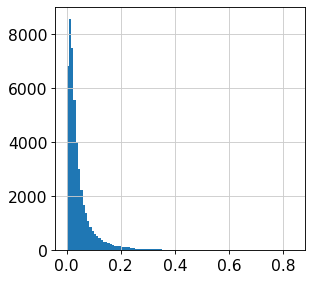

In [93]:
_ = plt.hist(refit_usage_norm['Soup'], bins=100)

In [94]:
adata.obs['Soup_Usage'] = refit_usage_norm.loc[adata.obs.index, 'Soup']

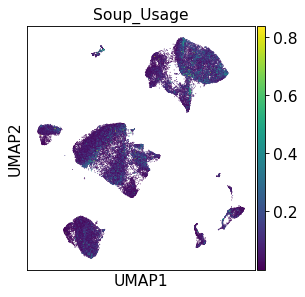

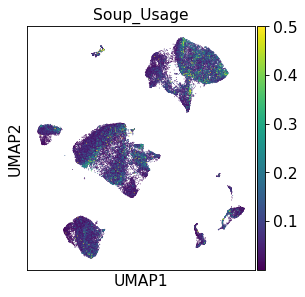

In [95]:
sc.pl.umap(adata, color='Soup_Usage')
sc.pl.umap(adata, color='Soup_Usage', vmax=.5)

## Determine infected cells

In [96]:
soup_profiles = pd.read_csv(soupfn, sep='\t', index_col=0)
soup_profiles.index = [x.split('__')[1] for x in soup_profiles.index]
soup_profiles = soup_profiles.groupby(axis=0, level=0).sum()
soup_profiles = soup_profiles.loc[adata.raw.var.index,:].T

ebovind = [x for x in soup_profiles.columns  if 'EBOV' in x]
soup_profiles_pseduo = (soup_profiles+.1)
ebov_soup_pct = soup_profiles_pseduo.loc[:, ebovind].sum(axis=1) / soup_profiles_pseduo.sum(axis=1)
ebov_soup_pct = dict(ebov_soup_pct)
ebov_soup_pct

{'EV0001.H024.fresh.a1.std.EX1.irrad-moi5e-1_88_Novaseq_20190530': 0.02020703056554513,
 'EV0001.H024.fresh.a1.std.EX1.irrad-moi5e0_88_Novaseq_20190530': 0.30305817436828336,
 'EV0001.H024.fresh.a1.std.EX1.live-moi5e-1_88_Novaseq_20190530': 0.01985405066543098,
 'EV0001.H024.fresh.a1.std.EX1.live-moi5e0_88_Novaseq_20190530': 0.07211985282449379,
 'EV0001.H024.fresh.a1.std.EX1.media_88_Novaseq_20190530': 0.015059202147351226,
 'EV0002.H024.fresh.a1.std.EX1.irrad-moi5e-1_88_Novaseq_20190530': 0.004777657826573226,
 'EV0002.H024.fresh.a1.std.EX1.irrad-moi5e0_88_Novaseq_20190530': 0.0986223495810961,
 'EV0002.H024.fresh.a1.std.EX1.live-moi5e-1_88_Novaseq_20190530': 0.03081214316911472,
 'EV0002.H024.fresh.a1.std.EX1.live-moi5e0_88_Novaseq_20190530': 0.13194994135953347,
 'EV0002.H024.fresh.a1.std.EX1.media_88_Novaseq_20190530': 0.007751744958944154,
 'EV0003.H004.fresh.a1.std.EX2.irrad-moi1e-1_88_Novaseq_20190829': 8.950235469917883e-05,
 'EV0003.H004.fresh.a1.std.EX2.live-moi1e-1_88_Novas

In [97]:
adata

AnnData object with n_obs × n_vars = 48721 × 2092 
    obs: 'batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI', 'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes', 'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_hbb', 'leiden', 'leiden_lab', 'leiden_lab_group', 'Subclustering', 'SubclusteringGroup', 'Doublet', 'Usage_1', 'Usage_2', 'Usage_3', 'Usage_4', 'Usage_5', 'Usage_6', 'Usage_7', 'Usage_8', 'Usage_9', 'Usage_10', 'Usage_11', 'Usage_12', 'Usage_13', 'Soup_Usage'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'CC_Blacklist', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SubclusteringGroup_colors', 'condition_color

In [98]:
from scipy.stats import binom
adata.obs['pEBOV_Soup1'] = np.nan
for array in ebov_soup_pct.keys():
    ind = adata.obs['batch']==array
    ind = ind.index[ind]
    N = adata.obs.loc[ind, 'n_counts']
    Nebov = adata.obs.loc[ind, 'EBOV_counts']
    pEBOV_Soup1 = 1-binom.cdf(Nebov-1, p=ebov_soup_pct[array], n=N)
    adata.obs.loc[ind, 'pEBOV_Soup1'] = pEBOV_Soup1

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [99]:
adata.obs.loc[:, 'logEBOV_Soup1'] = -1*(adata.obs.loc[:, 'pEBOV_Soup1']+(10**-10)).apply(np.log10)

In [100]:
adata

AnnData object with n_obs × n_vars = 48721 × 2092 
    obs: 'batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI', 'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes', 'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_hbb', 'leiden', 'leiden_lab', 'leiden_lab_group', 'Subclustering', 'SubclusteringGroup', 'Doublet', 'Usage_1', 'Usage_2', 'Usage_3', 'Usage_4', 'Usage_5', 'Usage_6', 'Usage_7', 'Usage_8', 'Usage_9', 'Usage_10', 'Usage_11', 'Usage_12', 'Usage_13', 'Soup_Usage', 'pEBOV_Soup1', 'logEBOV_Soup1'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'CC_Blacklist', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Subclusterin

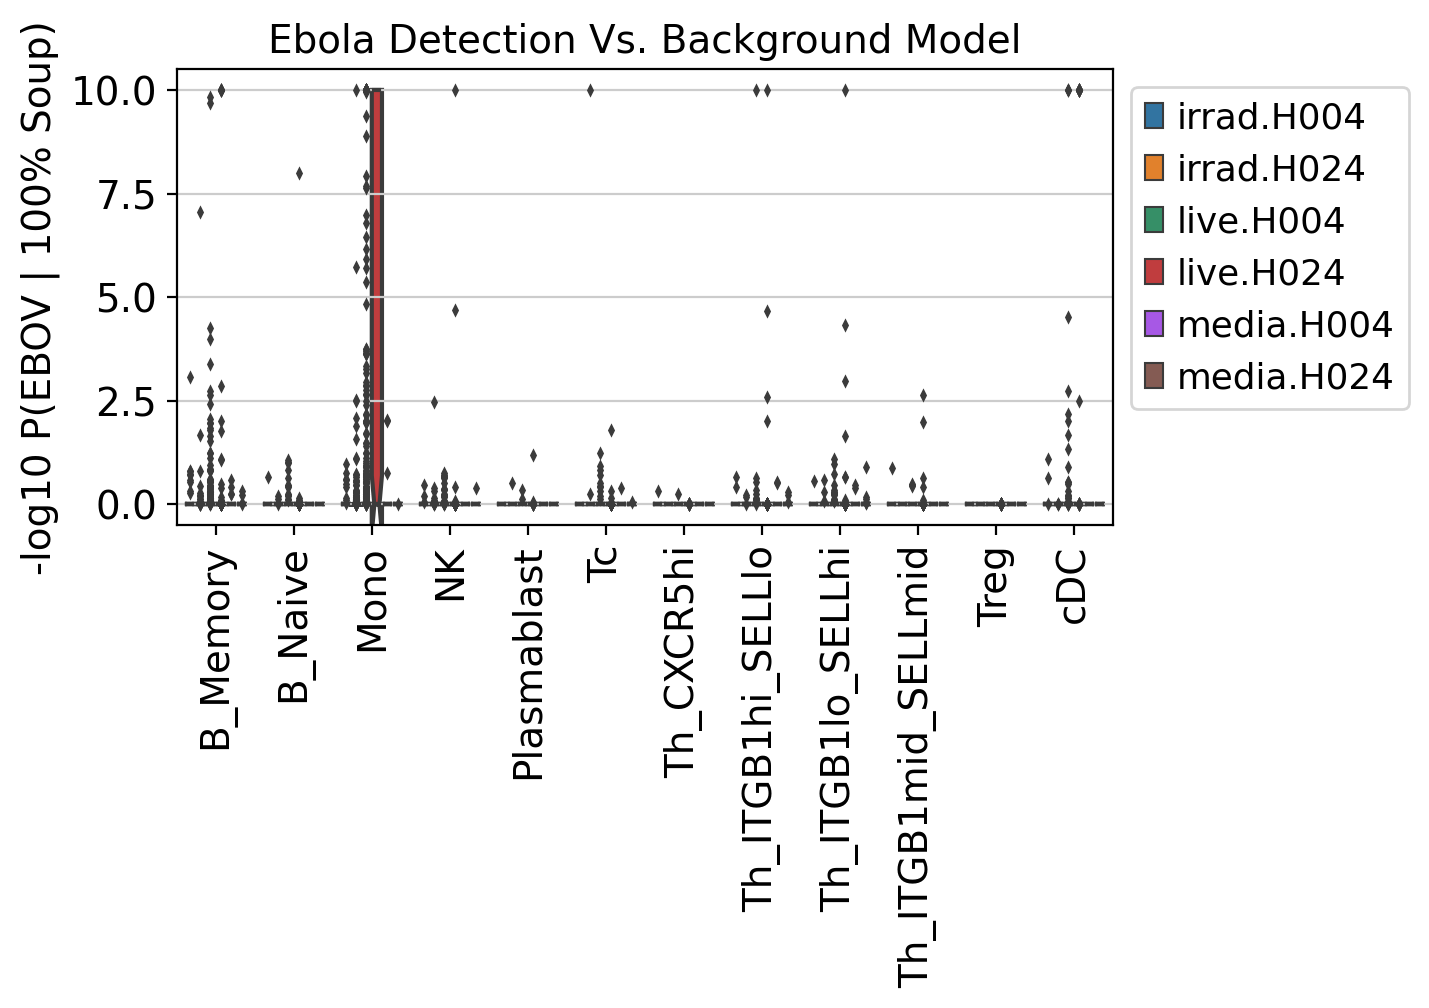

In [101]:
(fig,ax) = plt.subplots(1,1, figsize=(6,3), dpi=200)
hue_order = ['0', '3', '4', '5', '6', '7', '8']
sns.boxplot(x='SubclusteringGroup', y='logEBOV_Soup1', hue='condition',
            data=adata.obs, ax=ax, fliersize=2, notch=True, whis=.95)
ax.legend(bbox_to_anchor=(1.,1))
ax.set_ylabel('-log10 P(EBOV | 100% Soup)')
ax.set_xlabel('')
ax.set_title('Ebola Detection Vs. Background Model')
_ = ax.set_xticklabels([x.get_text() for x in ax.get_xticklabels()], rotation=90)

In [102]:
ebov_soup_pct_allcells = adata.obs['batch'].apply(lambda x: ebov_soup_pct[x]).astype(float)
null_exp_ebola_from_soup = ebov_soup_pct_allcells * adata.obs['Soup_Usage']
a_thresh = .01
thresh = (binom.isf(a_thresh, p=null_exp_ebola_from_soup, n=adata.obs['n_counts'])+1).astype(int)            
adata.obs['ebola_infection_threshold'] = thresh
adata.obs['Ebola_Positive'] = adata.obs['EBOV_counts']>adata.obs['ebola_infection_threshold']

In [103]:
adata.obs['Subclustering_reduced'] = adata.obs['SubclusteringGroup'].apply(lambda x: x.split('_')[0])

In [104]:
pd.crosstab(adata.obs['Subclustering_reduced'], adata.obs['condition'])

condition,irrad.H004,irrad.H024,live.H004,live.H024,media.H004,media.H024
Subclustering_reduced,,,,,,
B,891,1639,5178,4449,1767,1764
Mono,174,381,929,504,341,277
NK,464,632,2505,3026,625,699
Plasmablast,13,26,92,65,57,6
Tc,291,469,1659,1774,497,539
Th,805,1633,4991,5677,1496,1739
Treg,5,24,21,129,3,59
cDC,27,35,136,133,41,34


In [105]:
exvebovdat = adata.obs.copy()

In [106]:
remap = {'Th':'T', 'Tc':'T', 'cDC':'DC'}
exvebovdat['Subclustering_Clean'] = exvebovdat['Subclustering_reduced'].replace(remap)

In [107]:
remap = {'live.H024':'Live 24H', 'live.H004':'Live 4H', 'media.H024':'Media 24H', 'irrad.H024':'Irrad. 24H',
                  'media.H004':'Media 4H', 'irrad.H004':'Irrad. 4H'}

In [108]:
exvebovdat['Ebola_Positive100'] = exvebovdat['Ebola_Positive'].astype(float)*100
exvebovdat['condition_hour_clean'] = exvebovdat['condition'].replace(remap)
exvebovdat['condition_hour_clean'].value_counts()

Live 24H      15757
Live 4H       15511
Media 24H      5117
Irrad. 24H     4839
Media 4H       4827
Irrad. 4H      2670
Name: condition_hour_clean, dtype: int64

In [109]:
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

rcParams['xtick.major.pad']='1'
rcParams['ytick.major.pad']='1'

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [110]:
box_height=1.7
box_width=1.7
title_height=.15
left_space = .17
right_space = .98
bottom_space = .17
top_space = .98

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


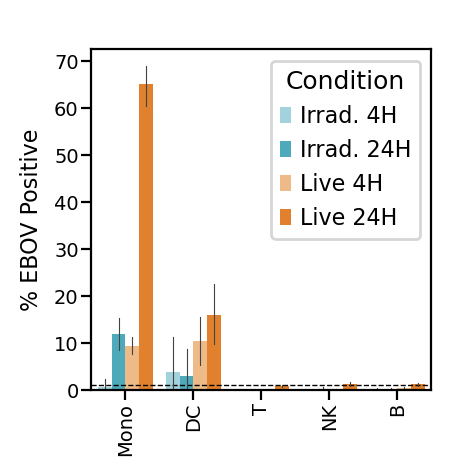

In [111]:

a_thresh = 1
cset = palettable.tableau.GreenOrange_12.hex_colors
condition_cmap = {'Live 24H':cset[2], 'Live 4H':cset[3], 'Irrad. 24H':cset[4],  'Irrad. 4H':cset[5], 'Media 24H':cset[0], 'Media 4H':cset[1]}


ax_width = box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(2, 1, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1],
          xscale='linear', yscale='linear',
          frameon=True)

title_ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=False, xticks=[],yticks=[],
          xlim=[0,1],
          ylim=[0,1])

error_kw=dict(lw=.7, capsize=.7, capthick=.5)

ct_order = ['Mono', 'DC', 'T', 'NK', 'B']
hue_order = ['Irrad. 4H', 'Irrad. 24H', 'Live 4H', 'Live 24H']
sns.barplot(x='Subclustering_Clean', y='Ebola_Positive100', hue='condition_hour_clean',
           order=ct_order, hue_order=hue_order, palette=condition_cmap,
            ax=ax, data=exvebovdat, errwidth=.4)

ax.set_ylabel('% EBOV Positive', fontsize=8)
ax.set_xlabel('', fontsize=8)
ax.set_xticklabels(ct_order, rotation=90)
ax.grid(False)

leg = ax.legend(loc='upper right', title='Condition', fontsize=8, markerscale=.1)
plt.setp(leg.get_title(),fontsize=9)

xlim = ax.get_xlim()
ax.hlines(a_thresh, xmin=xlim[0], xmax=xlim[1], linestyle='--',linewidth=.5)
ax.set_xlim(xlim)

figure_file = os.path.join(results_dir, "EbolaTropism.ExVivo.Barplot.pdf")
fig.savefig(figure_file, dpi=300)

In [133]:
ind = exvebovdat['condition']=='live.H024'
ct=pd.crosstab([exvebovdat.loc[ind, 'Subclustering_reduced'], exvebovdat.loc[ind, 'animal']], exvebovdat.loc[ind, 'Ebola_Positive'])
ctnorm = ct.div(ct.sum(axis=1), axis=0)
ctnorm

Ebola_Positive                   False     True 
Subclustering_reduced animal                    
B                     EV0003  0.989126  0.010874
                      EV0004  0.988215  0.011785
Mono                  EV0003  0.239130  0.760870
                      EV0004  0.390710  0.609290
NK                    EV0003  0.991501  0.008499
                      EV0004  0.988028  0.011972
Plasmablast           EV0003  0.894737  0.105263
                      EV0004  0.956522  0.043478
Tc                    EV0003  0.995798  0.004202
                      EV0004  0.990755  0.009245
Th                    EV0003  0.996516  0.003484
                      EV0004  0.990185  0.009815
Treg                  EV0003  1.000000  0.000000
                      EV0004  1.000000  0.000000
cDC                   EV0003  0.840000  0.160000
                      EV0004  0.842593  0.157407

In [134]:
ind = exvebovdat['condition']=='live.H024'
ct=pd.crosstab(exvebovdat.loc[ind, 'Subclustering_reduced'], exvebovdat.loc[ind, 'Ebola_Positive'])
ctnorm = ct.div(ct.sum(axis=1), axis=0)
ctnorm

Ebola_Positive,False,True
Subclustering_reduced,,
B,0.988762,0.011238
Mono,0.349206,0.650794
NK,0.988434,0.011566
Plasmablast,0.938462,0.061538
Tc,0.992108,0.007892
Th,0.992426,0.007574
Treg,1.000000,0.000000
cDC,0.842105,0.157895


In [112]:
exvivoebovfn = os.path.join(adir, name+'.EBOVINFOwithMDCK.20200113.tsv')
print(exvivoebovfn)

../../../data/ExVivo/Seqwell/cNMF.exvivo2_20200318_mmul8_V4.EBOVINFOwithMDCK.20200113.tsv


In [113]:
exvebovdat.to_csv(exvivoebovfn, sep='\t')

In [114]:
for c in ['Soup_Usage', 'ebola_infection_threshold', 'Ebola_Positive']:
    adata_annot.obs[c] = adata.obs.loc[adata_annot.obs.index,c]

In [115]:
processed_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.EBOVcalls.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(processed_file)
save_adata(adata_annot, processed_file, gcs=gcs)

../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.Blacklist.HVGs_None.scale.SubclusterMBTNK.UMAP.EBOVcalls.h5ad
Only considering the two last: ['.EBOVcalls', '.h5ad'].
Only considering the two last: ['.EBOVcalls', '.h5ad'].


In [116]:
exvebovdat['condition'].unique()

[irrad.H004, live.H004, media.H004, irrad.H024, live.H024, media.H024]
Categories (6, object): [irrad.H004, live.H004, media.H004, irrad.H024, live.H024, media.H024]

In [117]:
from scipy.stats import binom, norm
import sys

def get_sensitivity_convolution(thresh, p1, n1, p2, n2):
    a1 = binom.pmf(np.arange(0, thresh), n=n1, p=p1)
    a2 = binom.pmf(np.arange(0, thresh), n=n2, p=p2)   
    return(1 - np.convolve(a1,a2)[:thresh].sum())


assumed_percent_ebov = [.001, .01]
soup_pcts = [.01, .1, .5]
specificity_thresholds = list(np.logspace(-5, -1, num=30, base=10)) + list(np.linspace(.12, 1, num=30))

sensitivity_vs_spec_approx = pd.DataFrame(index=specificity_thresholds, columns = [(x,y) for x in assumed_percent_ebov for y in soup_pcts])
sensitivity_vs_spec_approx[(.001, 'emperical')] = np.nan
sensitivity_vs_spec_approx[(.01, 'emperical')] = np.nan
#sensitivity_vs_spec_approx[(.001, 'emperical X 2')] = np.nan
#sensitivity_vs_spec_approx[(.01, 'emperical X 2')] = np.nan

np.random.seed(10)
nsample=2000
ind = ~exvebovdat['condition'].isin(['live.H024', 'live.H004'])
subsample = exvebovdat.loc[ind,:].sample(nsample, replace=False).index

N = exvebovdat.loc[:, 'n_counts'].astype(int)
ebov_soup_pct_allcells = exvebovdat['batch'].apply(lambda x: ebov_soup_pct[x]).astype(float)
Nsubset = N.loc[subsample]
ebov_soup_pct_subset = ebov_soup_pct_allcells.loc[subsample]

for epct in assumed_percent_ebov:
    for soup_percentage in soup_pcts:
        soup_est_counts = np.round(Nsubset*soup_percentage).astype(int).values
        cell_est_counts = (Nsubset-soup_est_counts).astype(int).values
        #mean = Nsubset*soup_percentage*ebov_soup_pct_subset + Nsubset*(1-soup_percentage)*epct
        #var = (Nsubset*soup_percentage*ebov_soup_pct_subset*(1-ebov_soup_pct_subset)) + (Nsubset*(1-soup_percentage)*epct*(1-epct))
        #sd = var**.5
        
        null_exp_ebola_from_soup = ebov_soup_pct_subset*soup_percentage
        for a in specificity_thresholds:
            print(epct, soup_percentage, a)
            thresh = (binom.isf(a, p=null_exp_ebola_from_soup, n=Nsubset)+1).astype(int)
            prob = []
            for i in range(len(thresh)):
                if thresh[i] > 0:
                    prob.append(get_sensitivity_convolution(thresh[i], epct, cell_est_counts[i],
                                                        ebov_soup_pct_subset[i], soup_est_counts[i]))
                else:
                    prob.append(1)
            
            #prob = norm.sf(thresh, loc=mean, scale=sd)
            sensitivity_vs_spec_approx.at[a, (epct, soup_percentage)] = np.mean(prob)


psoup_emperical = exvebovdat.loc[Nsubset.index, 'Soup_Usage']
soup_est_counts_emperical = np.round(Nsubset*psoup_emperical).astype(int).values
cell_est_counts_emperical = (Nsubset-soup_est_counts_emperical).astype(int).values
null_exp_ebola_from_soup = psoup_emperical*ebov_soup_pct_subset
for epct in assumed_percent_ebov:
    for a in specificity_thresholds:
        print(epct, 'empirical', a)
        thresh = (binom.isf(a, p=null_exp_ebola_from_soup, n=Nsubset)+1).astype(int)
        prob = []
        for i in range(len(thresh)):
            if thresh[i] > 0:
                prob.append(get_sensitivity_convolution(thresh[i], epct, cell_est_counts_emperical[i],
                                                        ebov_soup_pct_subset[i], soup_est_counts_emperical[i]))
            else:
                prob.append(1)
                
        sensitivity_vs_spec_approx.at[a, (epct, 'emperical')] = np.mean(prob)     

0.001 0.01 1e-05
0.001 0.01 1.3738237958832637e-05
0.001 0.01 1.8873918221350958e-05
0.001 0.01 2.592943797404667e-05
0.001 0.01 3.5622478902624444e-05
0.001 0.01 4.893900918477499e-05
0.001 0.01 6.723357536499335e-05
0.001 0.01 9.236708571873866e-05
0.001 0.01 0.0001268961003167922
0.001 0.01 0.00017433288221999874
0.001 0.01 0.0002395026619987486
0.001 0.01 0.00032903445623126676
0.001 0.01 0.00045203536563602405
0.001 0.01 0.0006210169418915617
0.001 0.01 0.0008531678524172806
0.001 0.01 0.0011721022975334804
0.001 0.01 0.0016102620275609393
0.001 0.01 0.002212216291070448
0.001 0.01 0.0030391953823131978
0.001 0.01 0.0041753189365604
0.001 0.01 0.005736152510448681
0.001 0.01 0.007880462815669913
0.001 0.01 0.01082636733874054
0.001 0.01 0.014873521072935119
0.001 0.01 0.020433597178569417
0.001 0.01 0.028072162039411756
0.001 0.01 0.03856620421163472
0.001 0.01 0.05298316906283707
0.001 0.01 0.07278953843983146
0.001 0.01 0.1
0.001 0.01 0.12
0.001 0.01 0.1503448275862069
0.001 0.0

[Text(0, 0, '0'),
 Text(0, 0, '0.25'),
 Text(0, 0, '0.5'),
 Text(0, 0, '0.75'),
 Text(0, 0, '1.0')]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


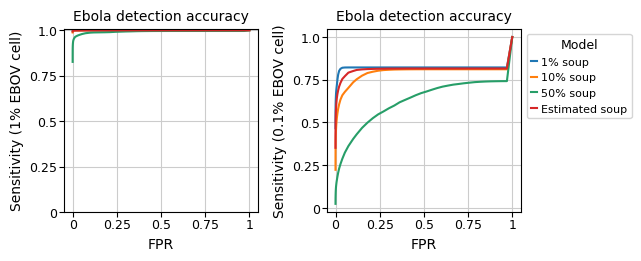

In [118]:
from matplotlib import gridspec
fig = plt.figure(constrained_layout=True, figsize=(6.3, 2.5), dpi=100)
gs = gridspec.GridSpec(1, 2, figure=fig, left=0.3,
                       bottom=.3, right=5, top=2.2, wspace=.3)

#xticks=[], yticks=[], 
ax1 = fig.add_subplot(gs[0], title='Ebola detection accuracy', xlabel='FPR', ylabel='Sensitivity (1% EBOV cell)')
ax2 = fig.add_subplot(gs[1], title='Ebola detection accuracy', xlabel='FPR', ylabel='Sensitivity (.1% EBOV cell)')

lab = ['1% soup', '10% soup', '50% soup', 'Estimated soup']
soup_pct = [.01, .1, .5, 'emperical']

for (i,c) in enumerate(soup_pct):
    ax1.plot(sensitivity_vs_spec_approx.index, sensitivity_vs_spec_approx[(.01, c)], label=lab[i])
    
for (i,c) in enumerate(soup_pct):
    ax2.plot(sensitivity_vs_spec_approx.index, sensitivity_vs_spec_approx[(.001, c)], label=lab[i])

#legend = ax1.legend(loc='lower right', fontsize=8, title='Model')
#plt.setp(legend.get_title(),fontsize=9)

legend = ax2.legend(bbox_to_anchor=(1,1), fontsize=8, title='Model')
plt.setp(legend.get_title(),fontsize=9)

ax1.set_title('Ebola detection accuracy', fontsize=10)
ax1.set_xlabel('FPR', fontsize=10)
ax1.set_ylabel('Sensitivity (1% EBOV cell)', fontsize=10)

ax2.set_title('Ebola detection accuracy', fontsize=10)
ax2.set_xlabel('FPR', fontsize=10)
ax2.set_ylabel('Sensitivity (0.1% EBOV cell)', fontsize=10)

ax1.set_xticks([0, .25, .5, .75, 1])
ax1.set_xticklabels([0, .25, .5, .75, 1], fontsize=9)

ax2.set_xticks([0, .25, .5, .75, 1])
ax2.set_xticklabels([0, .25, .5, .75, 1], fontsize=9)

ax1.set_yticks([0, .25, .5, .75, 1.0])
ax1.set_yticklabels([0, .25, .5, .75, 1.0], fontsize=9)

ax2.set_yticks([0, .25, .5, .75, 1.0])
ax2.set_yticklabels([0, .25, .5, .75, 1.0], fontsize=9)

In [119]:
roc_exvivo = sensitivity_vs_spec_approx.copy()


In [120]:
roc_exvivo['specificity'] = roc_exvivo.index

In [121]:
roc_exvivo.index = np.arange(roc_exvivo.shape[0])

In [122]:
roc_exvivo.columns = [str(x).replace('(', 'PctVirus_').replace(', ', '__PctSoup_').replace(')', '').replace("'", '') for x in roc_exvivo.columns]

In [123]:
roc_fn = os.path.join(adir, name+'.ROCcalculation.tsv')
roc_exvivo.to_csv(roc_fn, sep='\t')

In [124]:
roc_exvivo.head()

,PctVirus_0.001__PctSoup_0.01,PctVirus_0.001__PctSoup_0.1,PctVirus_0.001__PctSoup_0.5,PctVirus_0.01__PctSoup_0.01,PctVirus_0.01__PctSoup_0.1,PctVirus_0.01__PctSoup_0.5,PctVirus_0.001__PctSoup_emperical,PctVirus_0.01__PctSoup_emperical,specificity
0,0.466281,0.222966,0.0236873,0.996681,0.987738,0.826151,0.351716,0.992923,0.000010
1,0.473835,0.232684,0.0256032,0.997206,0.988032,0.832409,0.361934,0.993186,0.000014
2,0.480867,0.243624,0.0279996,0.997739,0.988816,0.838522,0.374434,0.993501,0.000019
3,0.488428,0.254954,0.030588,0.998021,0.989952,0.844522,0.386520,0.993733,0.000026
4,0.498377,0.267487,0.0333194,0.998276,0.990622,0.852356,0.398786,0.994182,0.000036


In [126]:
roc_invivo_fn = '../../../data/InVivo/Seqwell/cNMF.invivo_all_20200318_mmul8_V4_fixid.ROCcalculation.tsv'
roc_invivo = pd.read_csv(roc_invivo_fn, sep='\t', index_col=0)
roc_invivo.head()

,PctVirus_0.001__PctSoup_0.01,PctVirus_0.001__PctSoup_0.1,PctVirus_0.001__PctSoup_0.5,PctVirus_0.01__PctSoup_0.01,PctVirus_0.01__PctSoup_0.1,PctVirus_0.01__PctSoup_0.5,PctVirus_0.001__PctSoup_emperical,PctVirus_0.01__PctSoup_emperical,specificity
0,0.290972,0.144976,0.036273,0.985564,0.945406,0.622879,0.271720,0.945726,0.000010
1,0.302941,0.149536,0.037495,0.986179,0.948281,0.633200,0.279424,0.948106,0.000014
2,0.314876,0.154268,0.038906,0.986735,0.950292,0.641758,0.287601,0.950039,0.000019
3,0.323381,0.162305,0.040992,0.987185,0.951895,0.652362,0.295857,0.952245,0.000026
4,0.332710,0.172318,0.042127,0.987829,0.953343,0.662300,0.306910,0.954144,0.000036


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


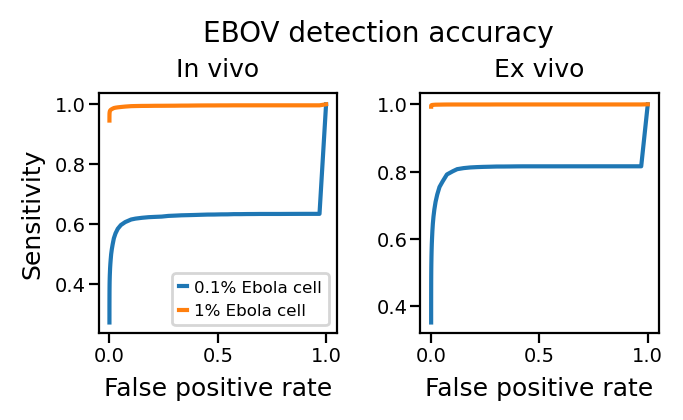

In [127]:
fig = plt.figure(figsize=(3.5, 2), dpi=200)
gs = gridspec.GridSpec(2, 2, fig, left=.15, bottom=.2, right=.95, top=.95,
                       hspace=0, wspace=0.35, height_ratios=[.2,.8])

left_ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, title='In vivo',
          xlabel='False positive rate', ylabel='Sensitivity')


right_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=True, title='Ex vivo',
          xlabel='False positive rate', ylabel='')

title_ax = fig.add_subplot(gs[0, :],
          xscale='linear', yscale='linear',
          frameon=False, title='',
          xlabel='', ylabel='', xticks=[],
          yticks=[], xlim=[0,1], ylim=[0,1])

title_ax.text(.5, 1, 'EBOV detection accuracy', va='center', ha='center',
              fontsize=10)


lab = ['0.1% Ebola cell', '1% Ebola cell']
cols = ['PctVirus_0.001__PctSoup_emperical','PctVirus_0.01__PctSoup_emperical']

for (i,c) in enumerate(cols):
    left_ax.plot(roc_invivo['specificity'],
                 roc_invivo[c], label=lab[i])
    right_ax.plot(roc_exvivo['specificity'],
                 roc_exvivo[c], label=lab[i])

legend = left_ax.legend(loc='lower right', fontsize=6)
left_ax.grid(False)
right_ax.grid(False)

figure_file = os.path.join(results_dir, "ROCebovDetect.InVivoExVivo.Barplot.pdf")
fig.savefig(figure_file, dpi=300)